Code adapted from work by [Damian Boh](https://medium.datadriveninvestor.com/sentiment-analysis-of-stocks-from-financial-news-using-python-82ebdcefb638).

In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [3]:
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
finwiz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}
tickers = ['TSLA', 'PLTR', 'AMD'] #, 'JPM', 'UNH', 'TGT', 'WMT']
for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [ ]:
# Read one single day of headlines for ‘AMZN’ 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into ‘amzn_tr’
amzn_tr = amzn.findAll('tr')
for i, table_row in enumerate(amzn_tr):
 # Read the text of the element ‘a’ into ‘link_text’
 a_text = table_row.a.text
 # Read the text of the element ‘td’ into ‘data_text’
 td_text = table_row.td.text
 # Print the contents of ‘link_text’ and ‘data_text’ 
 print(a_text)
 print(td_text)
 # Exit after printing 4 rows of data
 if i == 3:
    break

Cost of living: Eight top tips to save on online shopping
Oct-02-22 07:01PM
Will Amazon Be Worth More Than Apple by 2025?
09:45AM
Producer Bets Streamers Want the Next  Judge Judy, Not Game of Thrones
08:00AM
3 Spring-Loaded Stocks Ready to Soar When the Bear Market Ends
06:45AM


In [ ]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.get_text()
        # split text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element
        text = re.sub('^(.*(AM|PM))', "", text)
        #re.sub('^(.*Updated: )',"", date_div)

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news[:10] # print first 10 rows of news

[['TSLA',
  'Oct-02-22',
  '07:15PM',
  "Dow Jones Futures Rise As Bear Market Eyes Third Leg Down; Record Tesla Deliveries Fall Short Investor's Business Daily"],
 ['TSLA',
  'Oct-02-22',
  '05:31PM',
  'Tesla Warns About New Challenges Despite Record Deliveries TheStreet.com'],
 ['TSLA',
  'Oct-02-22',
  '04:44PM',
  'Tesla reports record deliveries, but numbers are still shy of analysts targets MarketWatch'],
 ['TSLA',
  'Oct-02-22',
  '03:56PM',
  'Tesla Deliveries Bounce Back to Record, Though Dented by Distribution Delays The Wall Street Journal'],
 ['TSLA',
  'Oct-02-22',
  '02:17PM',
  'Tesla blames logistics problems after delivering fewer cars than forecast Financial Times'],
 ['TSLA', 'Oct-02-22', '01:05PM', '\n01:05PM\nLoading…\n'],
 ['TSLA',
  'Oct-02-22',
  '01:05PM',
  "Tesla Stock Vs. BYD Stock: Tesla Deliveries Raise Demand Concerns; BYD Launches In Europe Investor's Business Daily"],
 ['TSLA',
  'Oct-02-22',
  '12:51PM',
  'Tesla Deliveries Set a Record. Shares Should

In [ ]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()
# Set column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)
# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()
# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')
# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date
parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,TSLA,2022-10-02,07:15PM,Dow Jones Futures Rise As Bear Market Eyes Thi...,0.000,1.000,0.000,0.0000
1,TSLA,2022-10-02,05:31PM,Tesla Warns About New Challenges Despite Recor...,0.144,0.722,0.134,-0.0258
2,TSLA,2022-10-02,04:44PM,"Tesla reports record deliveries, but numbers a...",0.172,0.828,0.000,-0.3612
3,TSLA,2022-10-02,03:56PM,"Tesla Deliveries Bounce Back to Record, Though...",0.000,1.000,0.000,0.0000
4,TSLA,2022-10-02,02:17PM,Tesla blames logistics problems after deliveri...,0.351,0.649,0.000,-0.6597


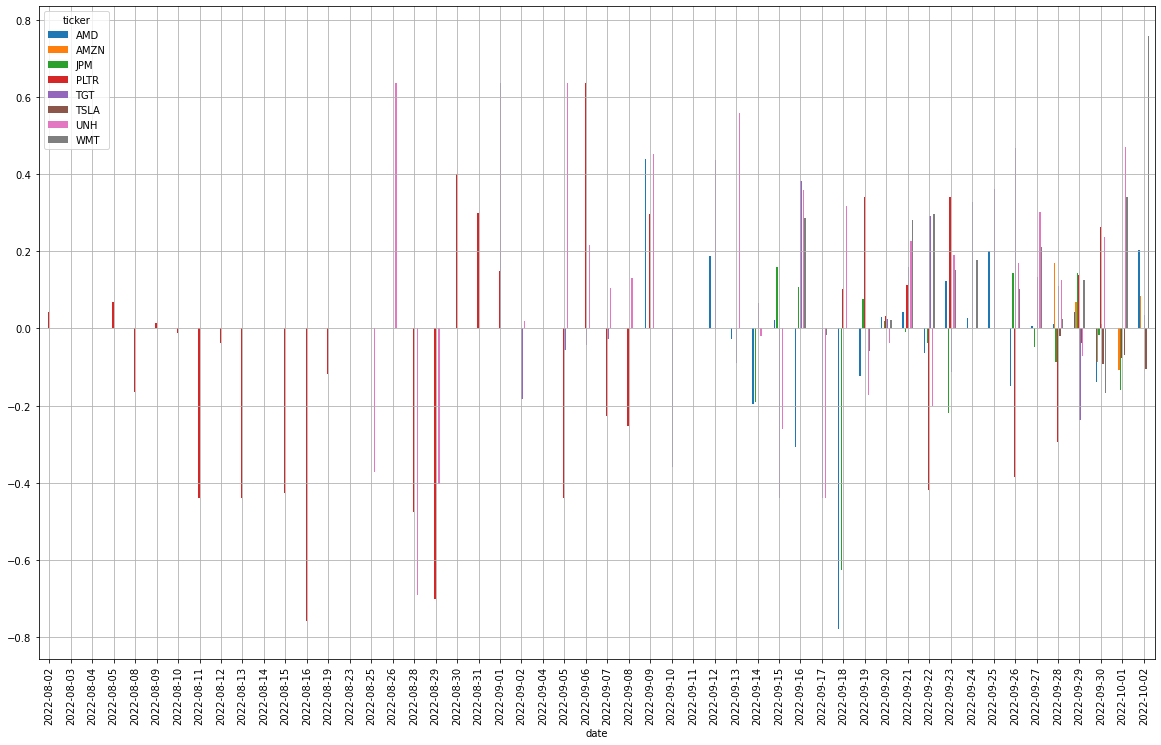

In [ ]:
plt.rcParams['figure.figsize'] = [20, 12]
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

['Oct-02-22', '07:15PM']